In [14]:
import numpy as np
import math
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation

from backend.resident_model import compute_resident
from backend.government_model import compute_government
from backend.developer_model import compute_developer
from backend.input_data import refresh_input


def map_input(x,far=3.5,precision=1):
    bcr = max(round(x[0],precision),0.1)
    tier = int(far/bcr)
    total = np.sum(x[1:])
    residential = min(max(round(x[1]/total,precision),0.1),0.7)
    office = min(max(round(x[2]/total,precision),0.1),0.7)
    amenity = min(max(round(x[3]/total,precision),0.1),0.7)
    civic = 1-residential-office-amenity
    np.set_printoptions(precision=precision, suppress=True)
    return [bcr,tier,residential,office,amenity,civic]




class MyProblem(ElementwiseProblem):
    def __init__(self):
        # 定义问题的参数
        super().__init__(n_var=5,  # 变量的数量
                         n_obj=3,  # 目标函数的数量
                         n_constr=1,  # 约束的数量
                         xl=np.array([0, 0, 0, 0, 0]),  # 变量的下界
                         xu=np.array([1, 1, 1, 1, 1]))  # 变量的上界

    def _evaluate(self, x, out, *args, **kwargs):
        # 输入参数
        bcr,tier,residential,office,amenity,civic = map_input(x)
        input_json = {"bcr": bcr, "tier": tier, "residential":residential, "office": office, "amenity": amenity, "civic": civic}
        refresh_input(input_json)

        # 计算目标函数的值
        score_res, indicator_res, index_res = compute_resident()
        score_gov, indicator_gov, index_gov = compute_government()
        score_dev, indicator_dev, index_dev = compute_developer()
        f1 = -1*score_res['score']
        f2 = -1*score_gov['score']
        f3 = -1*score_dev['score']

        # 设置输出
        out["F"] = [f1, f2, f3]
        out["G"] = [1 - (residential + office + amenity + civic)]

# 初始化问题
problem = MyProblem()

# 初始化算法
algorithm = NSGA2(
    pop_size=500,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=0.25, eta=20),
    eliminate_duplicates=True
)

# 定义停止准则
termination = get_termination("n_gen", 500)

# 执行优化
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)


/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_57219/1209308569.py:72: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", 500)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      4 |  0.000000E+00 |  1.887379E-17 |             - |             -
     2 |      600 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0645465879 |             f
     3 |      700 |      8 |  0.000000E+00 |  0.000000E+00 |  0.1000000000 |         nadir
     4 |      800 |     10 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      900 |     13 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |     1000 |     18 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     1100 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0044155868 |             f
     8 |     1200 |     19 |  0.000000E+00 |  0.000000E+00 |  0.4444444444 |         nadir
     9 |     1300 |     21 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     1400 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0416666667 |         nadir

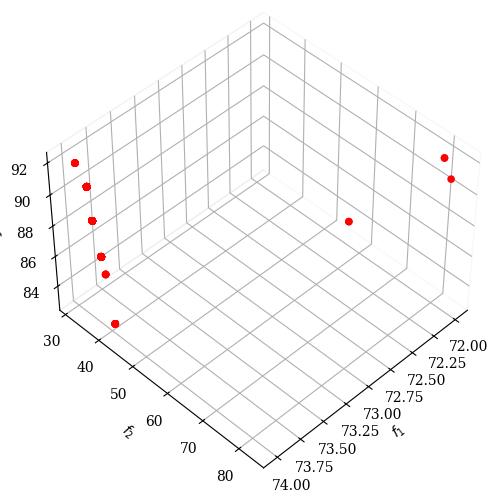

In [15]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(-1*res.F, color="red")
plot.show()

In [16]:
map_X = np.apply_along_axis(map_input, 1, res.X)
print(map_X)

[[1.  3.  0.1 0.3 0.6 0. ]
 [0.9 3.  0.1 0.1 0.7 0.1]
 [0.9 3.  0.1 0.2 0.1 0.6]
 ...
 [0.9 3.  0.1 0.1 0.3 0.5]
 [0.9 3.  0.1 0.1 0.3 0.5]
 [0.9 3.  0.1 0.1 0.4 0.4]]


In [17]:
print(-1*res.F)

[[72. 81. 92.]
 [74. 32. 92.]
 [74. 41. 83.]
 ...
 [74. 38. 87.]
 [74. 38. 87.]
 [74. 36. 89.]]


In [79]:
# 求最优解中总分最大的解
data = -1*res.F[np.where(map_X[:,-1]>=0.1)]
input = map_X[np.where(map_X[:,-1]>=0.1)]
id = np.where(np.sum(data,axis=1)==np.max(np.sum(data,axis=1)))

In [82]:
print("参数:",np.unique(input[id[0]]),"最高分:",np.unique(data[id[0]],axis=0),"总分:",np.unique(np.sum(data[id[0]],axis=1)))

参数: [0.1 0.3 0.5 0.9 3. ] 最高分: [[74. 35. 91.]] 总分: [200.]
